In [19]:
import pandas as pd
import geopandas as gpd
from numpy import arange
from shapely.geometry import Polygon
from explode import explode

# generates the following:
# 1 EEZ -> to create aoi
# 2 EEZ grid -> for downloading DEM from Earth Engine
# 3 envelope -> not used
# 4 aoi -> to create search area
# 5 search area -> for constraining search area in Earth Engine ocean object detection
# 6 aoi grid -> for extracting centroids in Earth Engine ocean object detection
wgs84= {'init' :'epsg:4326'}

In [20]:
#select country and load spatial data
n = 'CAN_E'
#n = 'GBR'
#n = 'FRO'
#n = 'NOR'
#n = 'IRL'
#n = 'CHL'
#n = 'KOR'
#n = 'JPN'


crs = 'EPSG:26898' #CAN_E
#crs = 'EPSG:3153' #CAN_W
#crs = 'EPSG:29902' #IRL
#crs = 'EPSG:4273' #NOR
#crs = 'EPSG:3144' #FRO
#crs = 'EPSG:27700'#GBR
country = gpd.read_file('./0_countries/' + n[0] + '_adm0.shp')

In [21]:
#1. extract EEZ
eez = gpd.read_file('/Users/Zack/0_sw_eez/eez_v11.shp')

#eez = eez[eez['GEONAME'] == 'Australian Exclusive Economic Zone']
#eez = eez[eez['GEONAME'] == 'South Korean Exclusive Economic Zone']
#eez = eez[eez['GEONAME'] == 'Canadian Exclusive Economic Zone']
#eez = eez[eez['GEONAME'] == 'Irish Exclusive Economic Zone']
#eez = eez[eez['GEONAME'] == 'Norwegian Exclusive Economic Zone']
#eez = eez[eez['GEONAME'] == 'Faeroe Exclusive Economic Zone']
#eez = eez[eez['GEONAME'] == 'United Kingdom Exclusive Economic Zone']

f = './2_eez/'
# eez.to_file(f + n + '_EEZ.geojson', driver="GeoJSON")
# eez.to_file(f + n + '_EEZ.shp')

#canada only
eez = gpd.read_file('./2_eez/' + n + '_EEZ.shp')
eez

,OBJECTID,FID_CAN_EE,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,...,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,ORIG_FID,FID_Export,dis,Shape_Leng,Shape_Area,geometry
0,5,1,8493.0,Canadian Exclusive Economic Zone,2169.0,200NM,2169.0,Canada,CAN,Canada,...,0.0,124.0,0.0,0.0,0,1,0,1175.664719,271.27402,POLYGON ((-57.42159827773827 61.05114899762822...


{'init': 'epsg:4326'}


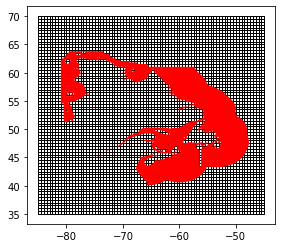

In [22]:
#generate grid covering area with specified degree grid
deg = 0.5

# #w canada
# lon = list(arange(40, 60, deg)) #+1
# lat = list(arange(-150, -110, deg)) #+1

#w canada
lon = list(arange(35, 70, deg)) #+1
lat = list(arange(-85, -45, deg)) #+1

#europe
# lon = list(arange(27, 75, deg)) #+1
# lat = list(arange(-18, 50, deg)) #+1

#create lat list
lat_list=[]
for i in range(len(lat)):
    lat_pt = lat[i], lat[i], (lat[i]+deg), (lat[i]+deg)
    lat_list.append(lat_pt)

#create lon list
lon_list=[]
for i in range(len(lon)):
    lon_pt = lon[i], (lon[i]+deg), (lon[i]+deg), lon[i]
    lon_list.append(lon_pt)

#create polygons
geom_list = []
for i in range(len(lon_list)):
    for j in range(len(lat_list)):
        geom = Polygon(zip(lat_list[j], lon_list[i]))
        df = gpd.GeoDataFrame(index=[0], geometry=[geom])  
        geom_list.append(df)
        
#combine polygons
grid = gpd.GeoDataFrame(pd.concat(geom_list, ignore_index=True), crs = {'init': 'epsg:4326'})
print(grid.crs)

#preview
ax = grid.plot(linewidth=1, edgecolor = 'black', facecolor = 'none')
eez.plot(linewidth=0, edgecolor = 'none', facecolor = 'red', ax=ax)

5600
1510
Wall time: 41.3 s


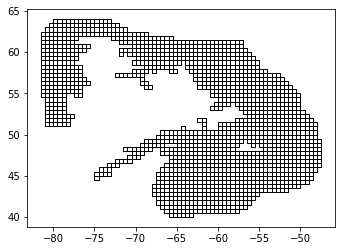

In [23]:
%%time
#select grid over eez
matches = grid.intersects(eez.unary_union)
grid_matches = grid.loc[matches]

grid_matches.plot(linewidth=1, edgecolor = 'black', facecolor = 'none')
print(len(grid))
print(len(grid_matches))

In [24]:
# #2. EEZ GRID - export
grid_matches.to_file('./2_eez/eez_grid/' + n + '_05deg_EEZ_area.shp')
grid_matches.to_file('./2_eez/eez_grid/' + n + '_05deg_EEZ_area.geojson', driver="GeoJSON")

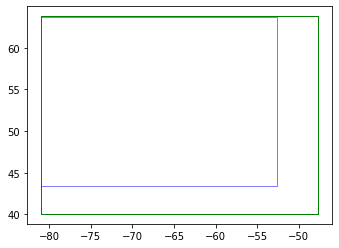

In [25]:
#3. create envelope

#generate envelopes
eez_e = gpd.GeoDataFrame(geometry = eez.envelope)
country_e = gpd.GeoDataFrame(geometry = country.envelope)

#combine envelopes
merge = gpd.overlay(country_e, eez_e, how = 'union')
merge['Dissolve'] = 0

#dissolve envelopes and make new envelope
envelope = merge.dissolve('Dissolve')
envelope = gpd.GeoDataFrame(geometry = envelope.envelope)
#print('envelope', envelope.crs)

#plot
#envelope = envelope.to_crs({'init': 'epsg:2100'})
ax = eez_e.plot(linewidth=.5, edgecolor = 'red', facecolor = 'none')
country_e.plot(linewidth=.5, edgecolor = 'blue', facecolor = 'none', ax=ax)
envelope.plot(linewidth=1, edgecolor = 'green', facecolor = 'none', ax=ax)

In [26]:
#export
envelope.to_file('./1_envelope/' + n + '_envelope.shp')
envelope.to_file('./1_envelope/' + n + '_envelope.geojson', driver="GeoJSON")

In [27]:
#load eez prep geojson
eez_prep = gpd.read_file('./2_eez/eez_prep/' + n + '.geojson')

Wall time: 2min 8s


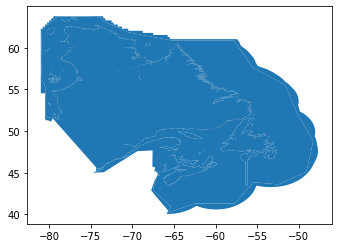

In [28]:
%%time 
merge = gpd.overlay(eez, eez_prep, how = 'union')
merge.plot()

Wall time: 10min 9s


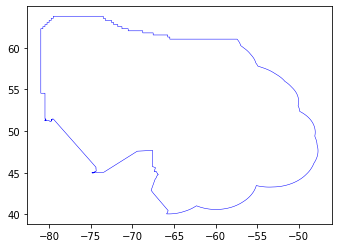

In [29]:
%%time 
#convert eez to an outline
merge = gpd.overlay(eez, eez_prep, how = 'union')
merge['Dissolve'] = 0
eez_dis = merge.dissolve('Dissolve')
eez_dis.plot(linewidth=.5, edgecolor = 'blue', facecolor = 'none')

Wall time: 25min 57s


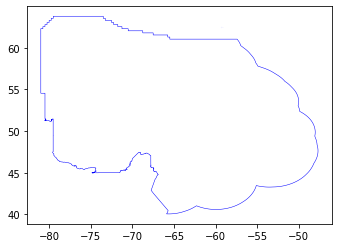

In [30]:
%%time 
#combine eez and country to create aoi
merge = gpd.overlay(eez_dis, country, how = 'union')
merge['Dissolve'] = 0
aoi = merge.dissolve('Dissolve')
aoi.plot(linewidth=.5, edgecolor = 'blue', facecolor = 'none')

In [31]:
#4. export aoi
aoi.to_file('./3_aoi/' + n + '_aoi.shp')
#aoi.to_file('./3_aoi/' + n + 'aoi.geojson', driver = "GeoJSON")

In [32]:
# #load land (generated from DEM)
# land = gpd.read_file('./5_land/' + n + '_land.shp')
# print(land.crs)
# land.plot()

In [33]:
# land = gpd.GeoDataFrame(geometry = land.geometry)
# land.crs = {'init' :crs}
# print(land.crs)

In [34]:
# %%time 
# #generate 100m buffer of land area
# land_100m = gpd.GeoDataFrame(geometry = land.buffer(100))
# land_100m.plot()
# #slow - GBR took 21min 39sec

In [35]:
# %%time 
# #export land with 100m buffer
# land_100m.to_file('./5_land/' + n + '_land_100m.shp')

In [36]:
gpd.read_file('./5_land/' + n + '_land_100m.shp')

DriverError: ./5_land/CAN_E_land_100m.shp: No such file or directory

In [ ]:
 %%time 
#load land with 100m buffer (generated from DEM)
land_100m = gpd.read_file('./5_land/' + n + '_land_100m.shp')
land_100m['geometry'] = land_100m['geometry'].to_crs(epsg=4326)
land_100m.crs = wgs84
print(land_100m.crs)
land_100m

In [ ]:
%%time 
#land_100m.plot()

In [ ]:
%%time
#union land 100m buffer with aoi
union = gpd.overlay(land_100m, aoi, how = 'union')
union.plot()

In [ ]:
union

In [ ]:
%%time
#verify the selection of water area 
select = 2
union['geometry'].loc[select]

In [ ]:
%%time
#select the water area to generate search area
search_area = gpd.GeoDataFrame(geometry = union.loc[[select], 'geometry'])
search_area

In [ ]:
print(search_area.crs)
#search_area.plot()

In [ ]:
#0 selects the search area?
sa = gpd.GeoDataFrame(geometry = explode(search_area).loc[0])
print(sa.crs)
sa.plot()

In [ ]:
sa

In [ ]:
%%time
#5. export search area
sa.to_file('./4_search_area/search_area_100m_' + n + '.shp')

In [ ]:
sa.crs = wgs84
print(sa.crs)
sa

In [ ]:
%%time
#generate search area grid
area = gpd.read_file('./4_search_area/search_area_100m_' + n + '.shp')
ax = grid.plot(linewidth=1, edgecolor = 'black', facecolor = 'none')
sa.plot(linewidth=0, edgecolor = 'none', facecolor = 'red', ax=ax)

In [ ]:
%%time
matches = grid.intersects(area.unary_union)
grid_matches = grid.loc[matches]
grid_matches.plot(linewidth=1, edgecolor = 'black', facecolor = 'none')

In [ ]:
#6. export - search area grid
f = './4_search_area/search_area_grid/'
grid_matches.to_file(f + n + '_05deg_search_area.geojson', driver='GeoJSON')
grid_matches.to_file(f + n + '_05deg_search_area.shp')